# Step 1: Prepare (images, label) split for train, test, validation sets

In [1]:
import numpy as np
import pandas as pd

In [2]:
# read data from csv file
def get_data(file):
    data = pd.read_csv(file)
    data = data.to_numpy()
    labels = []
    images = []
    
    for row_ind in range(data.shape[0]):
        labels.append(data[row_ind, 0])
        images.append(data[row_ind, 1:])
        
    images = np.reshape(images, newshape=(-1, 28, 28))
    labels = np.array(labels)
    return images, labels

X_train, y_train = get_data('../input/Kannada-MNIST/train.csv')
X_test, test_Id = get_data('../input/Kannada-MNIST/test.csv')

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(60000, 28, 28)
(60000,)
(5000, 28, 28)


In [3]:
pd.Series(y_train).value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
dtype: int64

Evenly distributed, non-skewed classes

In [4]:
from sklearn.model_selection import train_test_split
# make sure train and val are from same distribution whether is class counts or image-label quality
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42, shuffle=True)

8


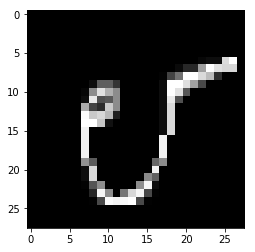

In [5]:
# visualization of one random data sample
from PIL import Image
import matplotlib.pyplot as plt
imgplot = plt.imshow(X_train[24], cmap='gray')
print(y_train[24])

# Step 2: One-hot encoder and ImageDataGenerator for image augmentation

In [6]:
# use one-hot encoder for multi-class classification
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

Using TensorFlow backend.


In [7]:
# add another dimension to the data since they are gray scale images
X_train = np.expand_dims(X_train, axis=3)
X_val = np.expand_dims(X_val, axis=3)
X_test = np.expand_dims(X_test, axis=3)

In [8]:
# do image augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rotation_range=10, 
        zoom_range = 0.1,  
        width_shift_range=0.1, 
        height_shift_range=0.1) 

print(X_train.shape)
print(X_val.shape)

(51000, 28, 28, 1)
(9000, 28, 28, 1)


# Step 3: Define simple CNN baseline model

In [9]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [10]:
from keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, AveragePooling2D, Flatten, Dense
from keras.models import Model

inputs = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
x = BatchNormalization(momentum=0.1)(x)
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization(momentum=0.1)(x)
x = AveragePooling2D((2, 2))(x)

x = Conv2D(16, (5, 5), padding='same', activation='relu')(x)
x = BatchNormalization(momentum=0.1)(x)
x = Conv2D(16, (5, 5), padding='same', activation='relu')(x)
x = BatchNormalization(momentum=0.1)(x)
x = AveragePooling2D((2, 2))(x)

x = Flatten()(x)
# from feature representation to categorical prob
x = Dense(100, activation='sigmoid')(x)
x = BatchNormalization(momentum=0.1)(x)
pred = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=pred)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
average_pooling2d_1 (Average (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 16)        1281

In [11]:
from keras.optimizers import Adam
adam = Adam(learning_rate=0.00005)

# Compile Model
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
# setup callbacks for auto earlystopping
es = EarlyStopping(monitor='val_accuracy', min_delta=0.00001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Train the Model
batch_size = 64
epochs = 50
history = model.fit_generator(train_datagen.flow(X_train, y_train, batch_size=batch_size), 
                              epochs=epochs,
                              steps_per_epoch=X_train.shape[0]//batch_size,
                              validation_data=(X_val, y_val),
                              callbacks=[es],
                              verbose=1)

Epoch 1/50
796/796 [==============================] - 22s 28ms/step - loss: 0.5886 - accuracy: 0.8221 - val_loss: 0.0973 - val_accuracy: 0.9760
Epoch 2/50
796/796 [==============================] - 19s 24ms/step - loss: 0.1523 - accuracy: 0.9607 - val_loss: 0.0565 - val_accuracy: 0.9848
Epoch 3/50
796/796 [==============================] - 18s 22ms/step - loss: 0.0916 - accuracy: 0.9762 - val_loss: 0.0373 - val_accuracy: 0.9898
Epoch 4/50
796/796 [==============================] - 19s 24ms/step - loss: 0.0681 - accuracy: 0.9818 - val_loss: 0.0306 - val_accuracy: 0.9913
Epoch 5/50
796/796 [==============================] - 19s 24ms/step - loss: 0.0544 - accuracy: 0.9854 - val_loss: 0.0290 - val_accuracy: 0.9916
Epoch 6/50
796/796 [==============================] - 18s 23ms/step - loss: 0.0463 - accuracy: 0.9878 - val_loss: 0.0233 - val_accuracy: 0.9931
Epoch 7/50
796/796 [==============================] - 18s 23ms/step - loss: 0.0406 - accuracy: 0.9889 - val_loss: 0.0277 - val_accuracy:

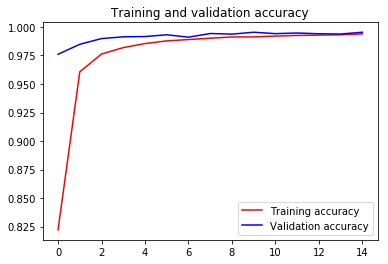

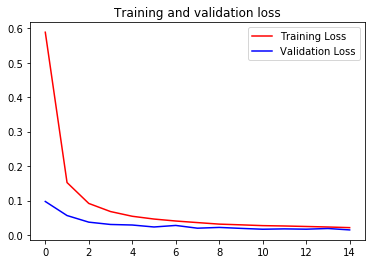

In [12]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# creates a new figure
plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Step 4: Error analysis

In [13]:
# confusion matrix for validation data
from sklearn.metrics import confusion_matrix
val_prediction = model.predict(X_val)
val_prediction = np.argmax(val_prediction, axis=1)

val_truth = np.argmax(y_val,axis=1)
# conf[i, j] is no. of true i are predicted to be j
conf = confusion_matrix(val_truth, val_prediction)
conf = pd.DataFrame(conf, index=range(0,10), columns=range(0,10))
from IPython.display import display
display(conf)

,0,1,2,3,4,5,6,7,8,9
0,848,9,0,0,0,0,0,0,1,0
1,0,913,0,0,0,0,0,0,0,0
2,1,0,907,0,0,0,0,0,0,0
3,0,0,0,881,0,2,0,7,0,0
4,0,0,0,0,924,1,0,0,0,1
5,0,0,0,2,3,869,0,0,0,0
6,0,0,0,1,0,0,852,5,0,4
7,0,0,0,0,0,0,0,933,0,0
8,0,0,0,0,0,1,0,0,917,0
9,0,0,0,0,0,0,4,0,0,914


Most of the wrong prediction comes some of the true 0s are predicted to be 1s, some of true 3s are predicted to be 7s, some of true 6s are predicted to be 7s, some of true 6s are predicted to be 9s, lets see why this is the case below.

Kannada numbers official representation
![](https://t3.ftcdn.net/jpg/01/62/22/58/500_F_162225807_ntQwmEkc76NoItsdipA1eNHQZKqdBoio.jpg)

In [18]:
# analyse how the majority wrong classification is caused
def case_analysis():
    for i in range(len(val_prediction)):
        if (val_prediction[i] == 1 and val_truth[i] == 0) or (val_prediction[i] == 7 and val_truth[i] == 3) or\
            (val_prediction[i] == 7 and val_truth[i] == 6) or (val_prediction[i] == 9 and val_truth[i] == 6):
            yield i

cases = list(case_analysis())  
print('no. of cases: {}'.format(len(cases)))

no. of cases: 25


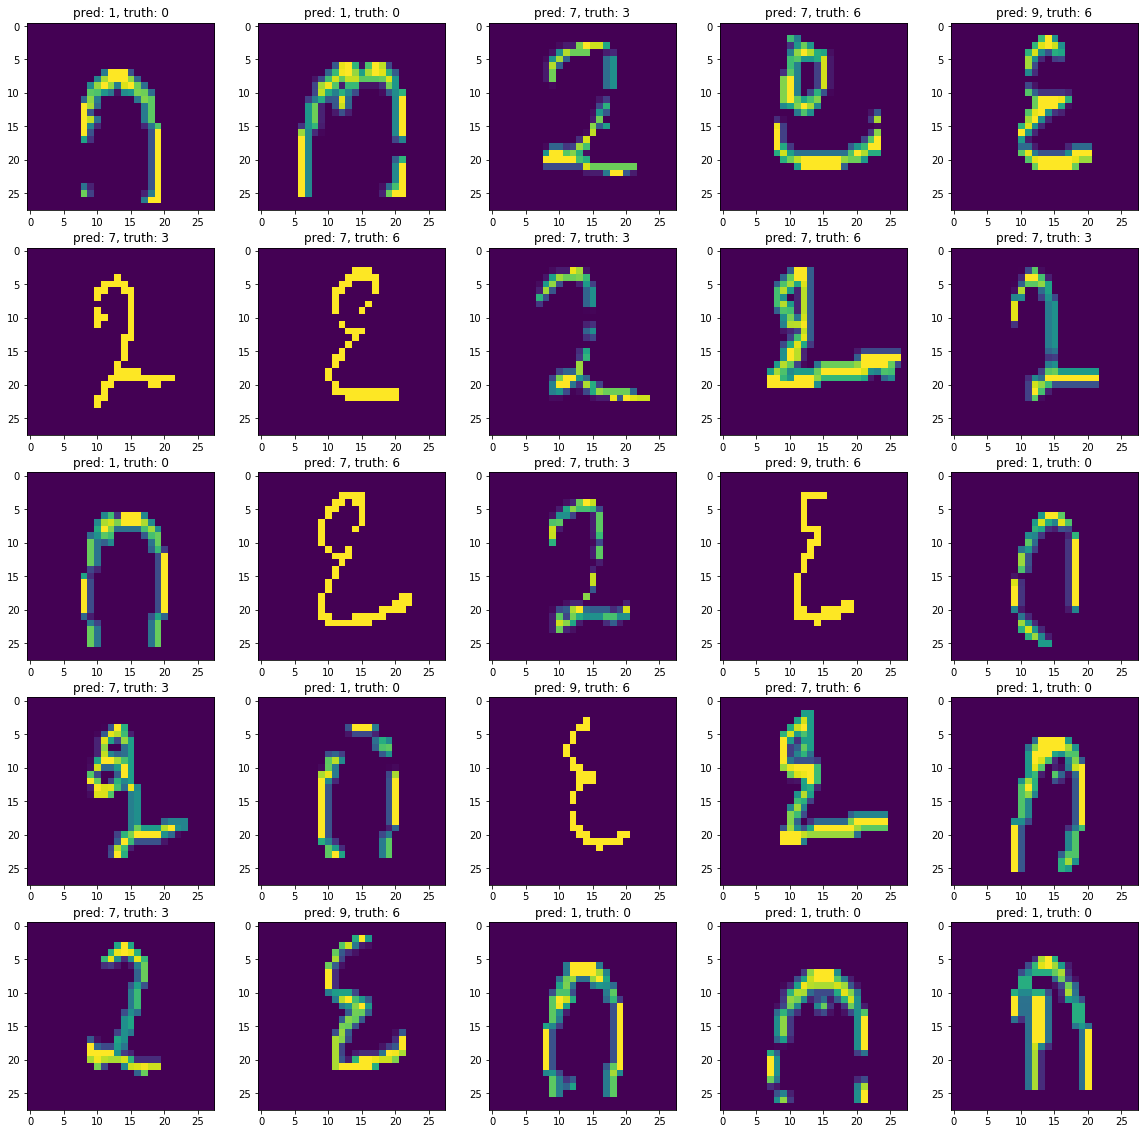

In [22]:
fig=plt.figure(figsize=(20, 20))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(X_val[cases[i-1]]))
    plt.title('pred: {}, truth: {}'.format(val_prediction[cases[i-1]], val_truth[cases[i-1]]))
plt.show()

As one can see from the above, almost all of the 'wrongly classified case' are due to wrong labels, for example, for the 'pred 1, truth 0' cases, human can tell it is obviously a 1 rather than 0 as the ground truth, the similar goes for 7 and 3, 7 and 6, 9 and 6. This is rather unfortunate due to human labelling during data preparation. Therefore, as far as this validation performance of our model, it is as perfect and as simple as a baseline model can get.

In [ ]:
# generate prediction for test set
prediction = model.predict(X_test)
prediction = np.argmax(prediction, axis=1)
submission_df = pd.DataFrame({'id':test_Id , 'label':prediction.astype(np.int32)})
# for kernel based competition
submission_df.to_csv('./submission.csv', index=False)